In [1]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns',100)
pd.set_option('display.max_columns',100)
pd.set_option('expand_frame_repr',False)
#import calendar

In [2]:
# Reading the input file

import os
cwd = os.getcwd()
train = cwd + "\\Source\\train.csv"
train = pd.read_csv(train)

test = cwd + "\\Source\\test.csv"
test = pd.read_csv(test)

In [3]:
# print(train[train['Employment.Type'].notnull()]['loan_default'].value_counts() / len(train[train['Employment.Type'].notnull()]))
# print(train[train['Employment.Type'].isnull()]['loan_default'].value_counts() / len(train[train['Employment.Type'].isnull()]))
# print(train[train['Employment.Type']=='Self employed']['loan_default'].value_counts() / len(train[train['Employment.Type']=='Self employed']))
# print(train[train['Employment.Type']=='Salaried']['loan_default'].value_counts() / len(train[train['Employment.Type']=='Salaried']))

# # Though there are not much differences between the default distribution, it appears as if the Salaried people are more 
# # likely to pay loan in item when compared to Self Employed

In [4]:
# Converting the date formats

train['Date.of.Birth'] = pd.to_datetime(train['Date.of.Birth'], dayfirst=True)
train['DisbursalDate'] = pd.to_datetime(train['DisbursalDate'], dayfirst=True)

test['Date.of.Birth'] = pd.to_datetime(test['Date.of.Birth'], dayfirst=True)
test['DisbursalDate'] = pd.to_datetime(test['DisbursalDate'], dayfirst=True)

In [5]:
# Feature Engineering

# Creating the age of loan applicant at the time of disbursal
train['Age_when_applying'] = (train['DisbursalDate'] - train['Date.of.Birth']).dt.days / 365
test['Age_when_applying'] = (train['DisbursalDate'] - test['Date.of.Birth']).dt.days / 365
train['Age_when_applying'] = np.where(train['Age_when_applying'] < 0, 100+train['Age_when_applying'], train['Age_when_applying'])
test['Age_when_applying'] = np.where(test['Age_when_applying'] < 0, 100+test['Age_when_applying'], test['Age_when_applying'])

# Creating the avg acct age and cred hist age in months
train['avg_acct_age_mnth'] = ((train['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + train['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
train['avg_credit_hist_mnth'] = ((train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

test['avg_acct_age_mnth'] = ((test['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + test['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
test['avg_credit_hist_mnth'] = ((test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

# Creating a Overdue Percentage for Primary and Seconardy Accounts

train['prim_overdue_acct_pct'] = (train['PRI.OVERDUE.ACCTS'] / train['PRI.NO.OF.ACCTS']).fillna(0)
train['sec_overdue_acct_pct'] = (train['SEC.OVERDUE.ACCTS'] / train['SEC.NO.OF.ACCTS']).fillna(0)

test['prim_overdue_acct_pct'] = (test['PRI.OVERDUE.ACCTS'] / test['PRI.NO.OF.ACCTS']).fillna(0)
test['sec_overdue_acct_pct'] = (test['SEC.OVERDUE.ACCTS'] / test['SEC.NO.OF.ACCTS']).fillna(0)

# Creating loan to asset ratio
train['asset_to_loan_pct'] =  train['asset_cost'] / train['disbursed_amount']
test['asset_to_loan_pct'] =  test['asset_cost'] / test['disbursed_amount']

# Imputing zero values of CNS Score (Test data also imputed with train mean)
train.loc[train['PERFORM_CNS.SCORE']==0, 'PERFORM_CNS.SCORE'] = train['PERFORM_CNS.SCORE'][train['PERFORM_CNS.SCORE'] != 0].mean()
test.loc[test['PERFORM_CNS.SCORE']==0, 'PERFORM_CNS.SCORE'] = train['PERFORM_CNS.SCORE'][train['PERFORM_CNS.SCORE'] != 0].mean()

# Creating a Total Outstanding balance
train['total_outstanding'] = train['disbursed_amount'] + train['PRI.CURRENT.BALANCE']
test['total_outstanding'] = test['disbursed_amount'] + test['PRI.CURRENT.BALANCE']

# Current to Outstanding ratio
train['curr_outstd_ratio'] = train['disbursed_amount'] / (train['disbursed_amount'] + train['PRI.CURRENT.BALANCE'])
test['curr_outstd_ratio'] = test['disbursed_amount'] / (test['disbursed_amount'] + test['PRI.CURRENT.BALANCE'])

# Previous Installment Capability
train['instalment_health'] = train['PRI.DISBURSED.AMOUNT'] / train['avg_credit_hist_mnth']
test['instalment_health'] = test['PRI.DISBURSED.AMOUNT'] / test['avg_credit_hist_mnth']


# Previous Installment to Current Disbursed Amt Ratio

train['inst_curr_disb_ratio'] = train['instalment_health'] / train['disbursed_amount']
test['inst_curr_disb_ratio'] = test['instalment_health'] / test['disbursed_amount']

# Filling missing values and inf values for Instalment Health and instalment to current disbursed ratio
train['instalment_health'].fillna(-9999, inplace=True)
test['instalment_health'].fillna(-9999, inplace=True)
train['inst_curr_disb_ratio'].fillna(-9.9, inplace=True)
test['inst_curr_disb_ratio'].fillna(-9.9, inplace=True)

train['instalment_health'] = np.where(np.isinf(train['instalment_health']),-999, train['instalment_health'])
test['instalment_health'] = np.where(np.isinf(test['instalment_health']),-999, test['instalment_health'])
train['inst_curr_disb_ratio'] = np.where(np.isinf(train['inst_curr_disb_ratio']),-0.9, train['inst_curr_disb_ratio'])
test['inst_curr_disb_ratio'] = np.where(np.isinf(test['inst_curr_disb_ratio']),-0.9, test['inst_curr_disb_ratio'])


# Impute Missing Employment Type with Unemployed
train['Employment.Type'] = np.where(train['Employment.Type'].isnull(), 'Unemployed', train['Employment.Type'])
test['Employment.Type'] = np.where(test['Employment.Type'].isnull(), 'Unemployed', test['Employment.Type'])

# Credit History Desc
train['cred_hist_desc'] = np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Very High Risk'), 'Very High Risk',
         np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Very Low Risk'), 'Very Low Risk',
                 np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Low Risk'), 'Low Risk',
                         np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Medium Risk'), 'Medium Risk',
                                 np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-High Risk'), 'High Risk',
                                         np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('No Bureau History'), 'No History',
                                                 np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored'), 'Not Scored', train['PERFORM_CNS.SCORE.DESCRIPTION'])))))))

test['cred_hist_desc'] = np.where(test['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Very High Risk'), 'Very High Risk',
         np.where(test['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Very Low Risk'), 'Very Low Risk',
                 np.where(test['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Low Risk'), 'Low Risk',
                         np.where(test['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-Medium Risk'), 'Medium Risk',
                                 np.where(test['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('-High Risk'), 'High Risk',
                                         np.where(test['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('No Bureau History'), 'No History',
                                                 np.where(test['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored'), 'Not Scored', test['PERFORM_CNS.SCORE.DESCRIPTION'])))))))

# Creating Age to Total Outstanding Ratio
train['age_outstd_ratio'] = train['Age_when_applying'] / train['total_outstanding']
test['age_outstd_ratio'] = test['Age_when_applying'] / test['total_outstanding']

In [6]:
# Selecting columns for predictors:

predictors = ['disbursed_amount', 'asset_cost', 'ltv','MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'avg_acct_age_mnth', 'avg_credit_hist_mnth',
       'Age_when_applying', 'prim_overdue_acct_pct', 'sec_overdue_acct_pct', 'asset_to_loan_pct']

# Predictors for Random Forest Classifer after optimizing for Feature Importance
predictors = ['disbursed_amount', 'asset_cost', 'ltv','Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'PERFORM_CNS.SCORE',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'avg_acct_age_mnth', 'avg_credit_hist_mnth',
       'Age_when_applying', 'prim_overdue_acct_pct','asset_to_loan_pct', 'cred_hist_desc', 'Employment.Type',
              'inst_curr_disb_ratio', 'instalment_health', 'curr_outstd_ratio', 'total_outstanding', 'age_outstd_ratio']

target = 'loan_default'
x = train[predictors]
y = train[target]
test_data = test[predictors]

In [7]:
# Creating Dummy Data

x = pd.get_dummies(x)
test_data = pd.get_dummies(test_data)

In [8]:
# # Standardizing the data to perform naive bayes

# from sklearn.preprocessing import QuantileTransformer

# transform_data = QuantileTransformer(output_distribution='normal')
# col_names = x.columns

# x = transform_data.fit_transform(x)
# x = pd.DataFrame(data=x, columns=col_names)

# test_data = transform_data.fit_transform(test_data)
# test_data = pd.DataFrame(data=test_data, columns=col_names)

# from sklearn.preprocessing import StandardScaler

# transform_data = StandardScaler()
# col_names = x.columns

# x = transform_data.fit_transform(x)
# x = pd.DataFrame(data=x, columns=col_names)

# test_data = transform_data.fit_transform(test_data)
# test_data = pd.DataFrame(data=test_data, columns=col_names)

In [9]:
# Train and Validation Split

from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(x,y, stratify=y, random_state=1, test_size=0.25)

In [10]:
# UNDER SAMPLING DATA
sampleData = x_train.copy()
sampleData['target'] = y_train

underSample_length = len(sampleData[sampleData.target == 1])

zero_target_indices = sampleData[sampleData.target == 0].index
random_indices = np.random.choice(zero_target_indices, underSample_length, replace=False)

target_data = sampleData[sampleData.target == 1]
zero_target_data = sampleData[sampleData.index.isin(random_indices)]
x_train = pd.concat([target_data, zero_target_data])

y_train = x_train['target']
x_train = x_train.drop('target', axis=1)

In [11]:
# # Running a Naive Bayes Model

# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

# # Training the model

# model.fit(x_train, y_train)
# train_predictions = model.predict(x_train)
# predictions = model.predict(x_validation)

In [12]:
# # Converting to lgbm dataset

# import lightgbm as lgb

# x_train = lgb.Dataset(x_train, free_raw_data=False)
# x_validation = lgb.Dataset(x_validation, free_raw_data=False)

In [13]:
# # Running LGBM

# # Setting Parameters:

# param = {
#         'num_leaves': 4,
#         'objective': 'binary',
#         'metric': 'auc',
#         'early_stopping_rounds':10,
#        }

# num_round=10
# model = lgb.train(param, x_train, num_round, valid_sets=[x_validation])

In [14]:
# Running a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=10, min_samples_leaf=3, bootstrap=True, oob_score=True, n_jobs=-1, random_state=10)

model = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=25, min_samples_leaf=5, oob_score=True, n_jobs=-1, random_state=10)

# Training the model

model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

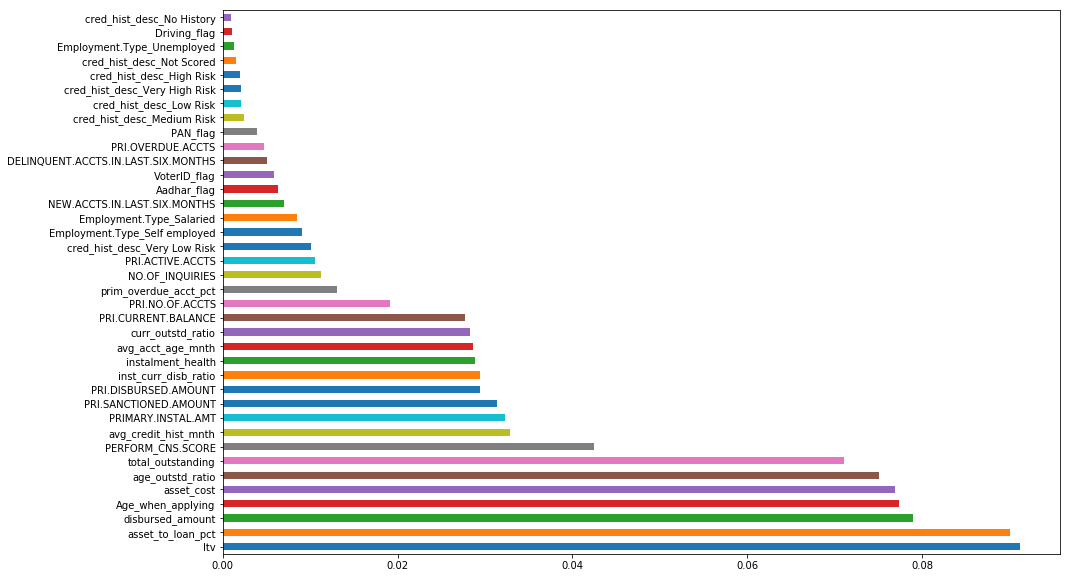

In [15]:
# Feature Importance Graph

plt.figure(figsize=(15,10))
feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(105).plot(kind='barh')

In [16]:
# Confusion Matrix and Report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data")
print(classification_report(y_validation, predictions))

Confustion Matrix for Training Data
[[30475  7483]
 [ 4274 33684]]
Confustion Matrix for Test Data
[[25186 20450]
 [ 4504  8149]]
Classification Report for Training Data
             precision    recall  f1-score   support

          0       0.88      0.80      0.84     37958
          1       0.82      0.89      0.85     37958

avg / total       0.85      0.85      0.84     75916

Classification Report for Test Data
             precision    recall  f1-score   support

          0       0.85      0.55      0.67     45636
          1       0.28      0.64      0.40     12653

avg / total       0.73      0.57      0.61     58289



AUROC Plot: 0.6335


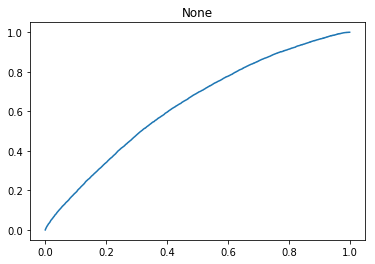

In [17]:
# AUC ROC CURVE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, predictions, average='weighted')

fpr, tpr, threshold = roc_curve(y_validation, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

In [33]:
# Applying Model for Test Data

predictions = model.predict_proba(test_data)[:,1]
id_code = test['UniqueID']

output = pd.DataFrame({'UniqueID': id_code, 'loan_default':predictions})


In [34]:
output.to_csv(cwd + "\\Output\\Submission 4 - RF RANDOM SEARCH BEST 0.63 AUC.csv", index=False)

In [27]:
# Creating a Random Grid

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# model = (n_estimators=500, criterion='gini', max_depth=25, min_samples_leaf=5, oob_score=True, n_jobs=-1, random_state=10)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=500, num=10)]

# Number of features to consider at every split (For max_features we can also consider sqrt or auto)
max_features = [int(x) for x in np.linspace(start= np.int(len(x_train.columns)/10),
                                            stop= np.int(len(x_train.columns)/2), num=5)]
# The split criterion
criterion = ['gini', 'entropy']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [5, 10, 15, 20, 25],
 'max_features': [3, 7, 11, 15, 19],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


In [28]:
# Performing the Random Search

# Use the random grid to search for best hyperparameters
# Let us use the base model "model" that is already created to tune the model against
model = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator = model, 
                                  param_distributions = random_grid, 
                                  n_iter = 20, cv = 3, verbose=250, random_state=42, n_jobs = -1)
# Fit the random search model
model_random.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Pickling array (shape=(38,), dtype=object).
Pickling array (shape=(75916,), dtype=int64).
Memmaping (shape=(19, 75916), dtype=int64) to new file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-f7dfa9b417580e1cbcc226636fddf8d5.pkl
Memmaping (shape=(9, 75916), dtype=float64) to new file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-56185d9461b8c797bec1e4a85f218503.pkl
Pickling array (shape=(10, 75916), dtype=uint8).
Pickling array (shape=(19,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(19,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(50610,), dtype=int32).
Pickling array (shape=(25306,), dtype=int32).
Pickling array (shape=(

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.9s
Pickling array (shape=(38,), dtype=object).
Pickling array (shape=(75916,), dtype=int64).
Memmaping (shape=(19, 75916), dtype=int64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-f7dfa9b417580e1cbcc226636fddf8d5.pkl
Memmaping (shape=(9, 75916), dtype=float64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-56185d9461b8c797bec1e4a85f218503.pkl
Pickling array (shape=(10, 75916), dtype=uint8).
Pickling array (shape=(19,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(19,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(50610,), dtype=int32).
Pickling array (shape=(25306,), dtype=int32).
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
Pickling array (shape=(38,), dtype=object).
Pickling array (shape=(75916,), dtype=int64).
Memmaping (shape=(19, 75916), dtype=int64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-f7dfa9b417580e1cbcc226636fddf8d5.pkl
Memmaping (shape=(9, 75916), dtype=float64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-56185d9461b8c797bec1e4a85f218503.pkl
Pickling array (shape=(10, 75916), dtype=uint8).
Pickling array (shape=(19,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(19,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(50610,), dtype=int32).
Pickling array (shape=(25306,), dtype=int32).
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  8.2min
Pickling array (shape=(38,), dtype=object).
Pickling array (shape=(75916,), dtype=int64).
Memmaping (shape=(19, 75916), dtype=int64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-f7dfa9b417580e1cbcc226636fddf8d5.pkl
Memmaping (shape=(9, 75916), dtype=float64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-56185d9461b8c797bec1e4a85f218503.pkl
Pickling array (shape=(10, 75916), dtype=uint8).
Pickling array (shape=(19,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(19,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(50610,), dtype=int32).
Pickling array (shape=(25306,), dtype=int32).
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.1min
Pickling array (shape=(38,), dtype=object).
Pickling array (shape=(75916,), dtype=int64).
Memmaping (shape=(19, 75916), dtype=int64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-f7dfa9b417580e1cbcc226636fddf8d5.pkl
Memmaping (shape=(9, 75916), dtype=float64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-56185d9461b8c797bec1e4a85f218503.pkl
Pickling array (shape=(10, 75916), dtype=uint8).
Pickling array (shape=(19,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(19,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(50610,), dtype=int32).
Pickling array (shape=(25306,), dtype=int32).
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 16.2min
Pickling array (shape=(38,), dtype=object).
Pickling array (shape=(75916,), dtype=int64).
Memmaping (shape=(19, 75916), dtype=int64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-f7dfa9b417580e1cbcc226636fddf8d5.pkl
Memmaping (shape=(9, 75916), dtype=float64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-56185d9461b8c797bec1e4a85f218503.pkl
Pickling array (shape=(10, 75916), dtype=uint8).
Pickling array (shape=(19,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(19,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(50610,), dtype=int32).
Pickling array (shape=(25306,), dtype=int32).
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Done  46 out of  60 | elapsed: 17.4min remaining:  5.3min
Pickling array (shape=(38,), dtype=object).
Pickling array (shape=(75916,), dtype=int64).
Memmaping (shape=(19, 75916), dtype=int64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-f7dfa9b417580e1cbcc226636fddf8d5.pkl
Memmaping (shape=(9, 75916), dtype=float64) to old file C:\Users\sivac\AppData\Local\Temp\joblib_memmaping_pool_20248_2505817835056\20248-2505813934032-56185d9461b8c797bec1e4a85f218503.pkl
Pickling array (shape=(10, 75916), dtype=uint8).
Pickling array (shape=(19,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(19,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(75916,), dtype=int64).
Pickling array (shape=(50610,), dtype=int32).
Pickling array (shape=(25306,), dtype=int32).
[Pa

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': [3, 7, 11, 15, 19], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 20, 25], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=250)

In [31]:
# Viewing the best parameters from the Random Search

# model_random.best_params_

# Below is the best parameter after tuning
# (n_estimators=300, min_samples_split=10,min_samples_leaf=2, max_features=11, max_depth = 15, criterion='entropy', bootstrap=True  )

# Below are alternative models with high score
# ALT MODEL 1
# (n_estimators=500, min_samples_split=5,min_samples_leaf=2, max_features=15, max_depth = 10, criterion='gini', bootstrap=True  )

# ALT MODEL 2
# (n_estimators=50, min_samples_split=10,min_samples_leaf=2, max_features=19, max_depth = 10, criterion='gini', bootstrap=True  )

# ALT MODEL 3
# (n_estimators=450, min_samples_split=10,min_samples_leaf=4, max_features=7, max_depth = 15, criterion='gini', bootstrap=False  )


In [39]:
# Training the model

model = RandomForestClassifier(n_estimators=450, min_samples_split=10,min_samples_leaf=4, max_features=7, max_depth = 15, criterion='gini', bootstrap=False, n_jobs=-1, random_state=10)

# Training the model

model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

# Confusion Matrix and Report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data")
print(classification_report(y_validation, predictions))

# AUC ROC CURVE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, predictions, average='weighted')

fpr, tpr, threshold = roc_curve(y_validation, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
print("AUROC Plot:", "%.4f" %auc)

Confustion Matrix for Training Data
[[27295 10663]
 [ 6066 31892]]
Confustion Matrix for Test Data
[[25017 20619]
 [ 4405  8248]]
Classification Report for Training Data
             precision    recall  f1-score   support

          0       0.82      0.72      0.77     37958
          1       0.75      0.84      0.79     37958

avg / total       0.78      0.78      0.78     75916

Classification Report for Test Data
             precision    recall  f1-score   support

          0       0.85      0.55      0.67     45636
          1       0.29      0.65      0.40     12653

avg / total       0.73      0.57      0.61     58289

AUROC Plot: 0.6355


In [40]:
# Applying Model for Test Data

predictions = model.predict_proba(test_data)[:,1]
id_code = test['UniqueID']

output = pd.DataFrame({'UniqueID': id_code, 'loan_default':predictions})
output.to_csv(cwd + "\\Output\\Submission 7 - RF RANDOM SEARCH ALTERNATE 3 MODEL 0.6355 AUC.csv", index=False)

In [22]:
# # Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydot

# # Pull out one tree from the forest
# tree = model.estimators_[5]

# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = x_train.columns, rounded = True, precision = 1)

# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')

# # Write graph to a png file
# graph.write_png('tree.png')

In [23]:
# Optimization Reference
# https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://www.mathworks.com/help/stats/tune-random-forest-using-quantile-error-and-bayesian-optimization.html
# https://www.kaggle.com/willkoehrsen/visualize-a-decision-tree-w-python-scikit-learn
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
# https://www.kaggle.com/residentmario/welcome-to-data-visualization
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0